In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'data': torch.FloatTensor(self.data[idx]),
            'label': torch.FloatTensor([self.labels[idx]])
        }
        return sample

In [3]:
data = pd.read_csv('../ea-based-nn-ik-solver/datasets/6DoF-6R-Puma260/data_3DoF-3R.csv')
data = np.array(data).astype(np.float32)
joints = data[:,-3:]
pos = data[:,:-3]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(joints, pos, test_size=0.2, random_state=42)

In [5]:
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Training Without Jacobians

In [10]:
input_size = joints.shape[1]
hidden_sizes = [64, 128]
output_size = pos.shape[1]
learning_rate = 0.0001
num_epochs = 10

model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
test_criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
training_total_loss = []
# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        
        # Forward pass
        outputs = model(inputs)
#         J_predicted = model.get_network_jacobian(inputs, outputs)
        
        loss = test_criterion(outputs, labels)
#         loss = combined_loss(output_poses, target_poses, J_predicted, target_jacobians, lambda_val=0.1)

        training_total_loss.append(loss.item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
correct = 0
total = 0
total_loss = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['data']
        labels = batch['label'].squeeze()
        outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
        loss = test_criterion(outputs, labels)
        total_loss.append(loss.item())
#         correct += (predicted == labels).sum().item()
mean_loss = np.mean(np.array(total_loss))
std_loss = np.std(np.array(total_loss))
print(f'mean Test Error: {mean_loss}')
print(f'Std Test Error: {std_loss}')

Epoch [1/10], Loss: 0.5878
Epoch [2/10], Loss: 0.3380
Epoch [3/10], Loss: 0.2421
Epoch [4/10], Loss: 0.2879
Epoch [5/10], Loss: 0.2793
Epoch [6/10], Loss: 0.1736
Epoch [7/10], Loss: 0.1318
Epoch [8/10], Loss: 0.1404
Epoch [9/10], Loss: 0.1008
Epoch [10/10], Loss: 0.0661
mean Test Error: 0.0850280596623345
Std Test Error: 0.015230809325917314


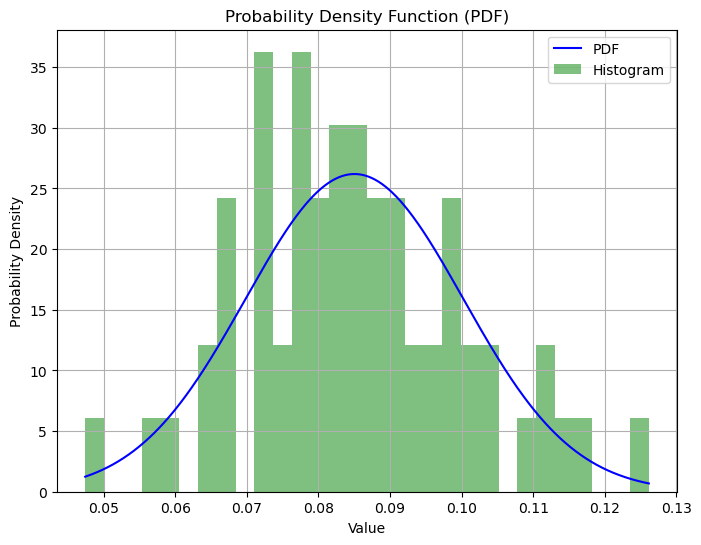

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = np.array(total_loss)

kde = norm(loc=np.mean(data), scale=np.std(data))
x_values = np.linspace(min(data), max(data), 1000)
pdf_values = kde.pdf(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.hist(data, bins=30, density=True, alpha=0.5, color='green', label='Histogram')  # Overlay a histogram for comparison
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

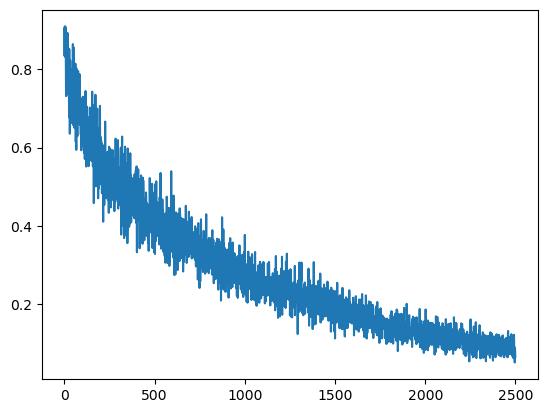

In [13]:
plt.plot(np.array(training_total_loss))

# Training with Jacobians

In [14]:
def get_network_jacobian(self, inputs, output_poses):
    # compute the Jacobian
    batch = inputs.shape[0]
    input_size = inputs.shape[1]
    output_size = self.output_dim #* self.dim_position

    # initialize a tensor to hold the Jacobian
    J = torch.zeros(batch, 1 , input_size, output_size)
    #print('J: ', J.shape)
    #print('output_size: ', output_size)
    #print('output_poses: ', output_poses.shape)
    #print('inputs: ', inputs.shape)

    t = time.time()
    for j in range(output_size):
        g = torch.autograd.grad(output_poses[:,j], 
                                inputs, 
                                grad_outputs=torch.ones_like(output_poses[:,j]),
                                retain_graph=True)
        g = g[0].permute(1,0)
        g = torch.reshape(g, (batch, 1, input_size))
        J[:,:,:,j] = g
        #print('g{}: {}'.format(j, g))
    #print('g: ', g.shape)
    #print('J: ', J.shape)
    J_reshape = torch.reshape(J, (batch, -1, self.input_dim))
    #print(J[0,:,:,0])
    #print(J[0,:,:,1])
    #print(J_reshape[0,:,:])
    #print('J_reshape: ', J_reshape.shape)

    J_reshape = J_reshape.permute(0, 2, 1) 
    #print('J_reshape: ', J_reshape.shape)
    #print(J_reshape[0,:,:])
    return J_reshape

In [15]:
def combined_loss(output_poses, target_poses, J_predicted, J_target, lambda_val):
    position_loss = torch.nn.functional.mse_loss(output_poses, target_poses)
    jacobian_loss = torch.nn.functional.mse_loss(J_predicted, J_target)
    return position_loss + lambda_val * jacobian_loss